<a href="https://colab.research.google.com/github/lukassanting/Idiom-Translation/blob/main/End_To_End/End_To_End_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training T5 - Prefix+Idiom



#0. Installs, Imports, Setup


##0.1 Import Libraries & Packages

In [1]:
!pip install sentencepiece -q
!pip install transformers -q
!pip install torch -q
!pip install rich[jupyter] -q

     |████████████████████████████████| 1.2 MB 14.2 MB/s 
     |████████████████████████████████| 4.2 MB 14.8 MB/s 
     |████████████████████████████████| 6.6 MB 50.6 MB/s 
     |████████████████████████████████| 596 kB 65.5 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 232 kB 8.4 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 


In [2]:
# Drive
from google.colab import drive

# Plots
import IPython
import IPython.display
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Util
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None)

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# rich: for a better display on terminal
from rich.table import Column, Table
from rich.text import Text
from rich import box
from rich.console import Console

# define a rich console logger
console = Console(record=True)

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

<Figure size 864x432 with 0 Axes>

##0.2. Import Data

Either upload the data to the shared Google Drive and use this to download, or upload it directly yourself (whatever is easier)

In [13]:
folder_name = 'repo'
!git clone https://github.com/lukassanting/Idiom-Translation/ 'repo'

Cloning into 'repo'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 203 (delta 88), reused 141 (delta 37), pack-reused 0
Receiving objects: 100% (203/203), 4.26 MiB | 1.77 MiB/s, done.
Resolving deltas: 100% (88/88), done.


##0.3 Setup functions & classes

###0.3.1 FUNC: display_df

In [4]:
# to display dataframe in ASCII format
def display_df(df):
    """display dataframe in ASCII format"""

    console = Console()
    table = Table(
        Column("source_text", justify="center"),
        Column("target_text", justify="center"),
        title="Sample Data",
        pad_edge=False,
        box=box.ASCII,
    )

    for i, row in enumerate(df.values.tolist()):
        table.add_row(row[0], row[1])

    console.print(table)

###0.3.2 CLASS: DataSet

A Dataset class for reading and loading the dataset into the dataloader, and then feed it into the neural network for fine-tuning the model.

In [5]:
class DataSet(Dataset):
    """
    Creating a dataset class for reading the dataset and
    loading it into the dataloader, to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, dataframe, tokenizer, source_len, target_len, source_text, target_text
    ):
        """
        Initializes a Dataset class

        Args:
            dataframe (pandas.DataFrame): Input dataframe
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = target_len
        self.target_text = self.data[target_text]
        self.source_text = self.data[source_text]

    def __len__(self):
        """returns the length of dataframe"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }

###0.3.3 FUNC: train

Train function, which will the put model on training mode, generate outputs and calculate loss

In [6]:
def train(epoch, tokenizer, model, device, loader, optimizer, train_batch_size):

    """
    Function to be called for training with the parameters passed from main function

    Takes 6 arguments as input:
    
        epoch: epoch
        tokenizer: T5 tokenizer
        model: T5 model
        loader: Train Dataloader
        optimizer: Optimizer
        train_batch_size: batch size for the training data


    """

    model.train()
    train_loss = 0
    train_batches = 0
    for _, data in enumerate(loader, 0):
        y = data["target_ids"].to(device, dtype=torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data["source_ids"].to(device, dtype=torch.long)
        mask = data["source_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            labels=lm_labels,
        )
        loss = outputs[0]
        train_loss += loss.item()
        train_batches += 1

        # Print training loss every 100 batches
        if _ % 100 == 0:
            #training_logger.add_row(str(epoch), str(_), str(loss.item()))
            console.print("Epoch: ", str(epoch), "Batch: ", str(_), "Loss: ", str(loss.item()))

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

    # Print average training loss over the epoch
    train_loss = train_loss/train_batches
    training_logger.add_row(str(epoch), str(train_loss))


###0.3.4 FUNC: validate

Validate function is same as the Train function, but for the validation data



In [7]:
def validate(epoch, tokenizer, model, device, loader, generate_outputs=True):

  """
  Function to evaluate model for predictions

  """
  model.eval()
  predictions = []
  actuals = []
  val_loss = 0
  batches = 0
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          # Find validation loss
          y_ids = y[:, :-1].contiguous()
          lm_labels = y[:, 1:].clone().detach()
          lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100

          outputs = model(
              input_ids=ids,
              attention_mask=mask,
              decoder_input_ids=y_ids,
              labels=lm_labels
              )
          loss = outputs[0]
          val_loss += loss.item()
          batches += 1

          # Generate outputs
          if generate_outputs:
            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]

            predictions.extend(preds)
            actuals.extend(target)

  # Save average loss over epoch
  val_loss = val_loss/batches
  if not generate_outputs:
    validation_logger.add_row(str(epoch), str(val_loss))

  return predictions, actuals

###0.3.5 FUNC: T5Trainer

T5Trainer is our main function. It accepts input data, model type, model paramters to fine-tune the model. Under the hood, it utilizes, our Dataset class for data handling, train function to fine tune the model, validate to evaluate the model.

In [8]:
def T5Trainer(
    train_data, val_data, source_text, target_text, model_params, output_dir="./outputs/"
):

    """
    T5 trainer has 6 arguments:

      train_data: Input dataframe of training data
      val_data: Input dataframe of validation data
      source_text: Column name of the input text i.e. idiomatic sentence
      target_text: Column name of the target text i.e. literal sentence
      model_params: T5 model parameters
      output_dir: Output directory to save fine tuned T5 model.

    """

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # tokenizer for encoding the text
    tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

    # Defining the model. The model is then sent to device (GPU/TPU)
    model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    model = model.to(device)

    # logging
    console.log(f"[Data]: Reading data...\n")

    # Importing the raw dataset
    train_data = train_data[[source_text, target_text]]
    train_data = train_data.reset_index(drop=True)
    val_data = val_data[[source_text, target_text]]
    val_data = val_data.reset_index(drop=True)

    display_df(train_data.head(2))

    # Creation of Dataset and Dataloader
    console.print(f"TRAIN Dataset: {train_data.shape}")
    console.print(f"VALIDATION Dataset: {val_data.shape}\n")

    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = DataSet(
        train_data,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )
    val_set = DataSet(
        val_data,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )

    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for training and validation.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )

    # Training loop
    console.log(f"[Initiating Fine Tuning]...\n")

    train_batch_size = model_params["TRAIN_BATCH_SIZE"]
    for epoch in range(model_params["TRAIN_EPOCHS"]):
        train(epoch, tokenizer, model, device, training_loader, optimizer, train_batch_size)
        validate(epoch, tokenizer, model, device, val_loader, generate_outputs=False)

    console.print("\n")
    console.print(training_logger)
    console.print("\n")
    console.print(validation_logger)

    console.log(f"[Saving Model]...\n")
    # Saving the model after training
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)

    # generating output for validation dataset
    console.log(f"[Generating Validation Outputs]...\n")
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({"Input": val_data[source_text], "Generated Text": predictions, "Actual Text": actuals})
    final_df.to_csv(os.path.join(output_dir, "predictions.csv"))

    console.save_text(os.path.join(output_dir, "logs.txt"))

    console.log(f"[Validation Outputs Generated.]\n")
    console.print(
        f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n"""
    )
    console.print(
        f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n"""
    )
    console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

# 1. Processing Data

In [9]:
def clean_dataset(data):
  data_clean = data.copy(deep=True)
  for i in range(len(data_clean.columns)):
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&apos;', '\'', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&quot;', '\"', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&#124;', '|', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&#93;', ']', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&#91;', '[', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&gt;', '>', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&lt;', '<', x))

  return data_clean

In [10]:
remove_wrong = True
clean = True
idiom_suffix = False



In [11]:
base_path="data/End-To-End/Dataset/en-de/"
pd.read_csv(base_path+'train_compare_cleaned.csv', header=0)

,Unnamed: 0,en,trans,de,Wrong
0,0,Could you please pass this request on to the P...,Could you please forward this question to the...,Könnten Sie diese Frage bitte an den Ratsvorsi...,NaN
1,1,"You may be forbidden to pass it on , and you a...",You may be prohibited from sharing them . And...,"Es ist Ihnen vielleicht verboten , sie weiterz...",NaN
2,2,I should like to thank everyone who has helped...,I think we can say thank you to everyone who ...,"Ich glaube , man darf hier allen , die mitgeho...",NaN
3,3,I will pass on your appreciation to my colleag...,I will convey your words of appreciation to G...,Ich werde Ihre anerkennenden Worte an Gay Mitc...,NaN
4,4,That is why our group is calling for the Confe...,That is why our group demands that the decisi...,"Darum fordert unsere Fraktion , dass die Entsc...",NaN
5,5,« Golden Pass » panorama railway section ; fro...,"""Golden Pass"" panoramic railway line - journe...",Panorama-Bahnstrecke « Golden Pass » - Fahrt v...,NaN
6,6,In front of this imposing background it was Be...,"In front of this impressive backdrop, it was p...",Vor dieser beeindruckenden Kulisse war es der ...,NaN
7,7,This is a commitment from Commissioner McCreev...,This is a firm commitment from Commissioner M...,Dies ist eine verbindliche Zusage von Kommissa...,NaN
8,8,Once we have gained experience of them for our...,"Once we have experienced them ourselves , we ...",Haben wir selbst einmal Erfahrung in ihnen gew...,NaN
9,9,"At this point , I would like to pass on immedi...",At this point I would like to go straight ahe...,An dieser Stelle möchte ich dann auch sofort ü...,NaN


In [14]:
import importlib
clean_dataset = importlib.import_module(folder_name + '.End-To-End.cleaning').clean_dataset

In [134]:
base_path="repo/End-To-End/Dataset/en-de/"
train_data = pd.read_csv(base_path+'train_compare_cleaned.csv', header=0, index_col=0)
test_data = pd.read_csv(base_path+'test_compare_cleaned.csv', header=0, index_col=0)

train_info = pd.read_csv(base_path+'idiom_trainplus.info',sep='\t',header=None,names=["spread", "en_idiom", "de_idiom",'frequency'])
test_info = pd.read_csv(base_path+'idiom_test.info',sep='\t',header=None,names=["spread", "en_idiom", "de_idiom",'frequency'])

train_data = pd.concat((train_data, train_info['en_idiom']), axis=1)
test_data = pd.concat((test_data, test_info['en_idiom']), axis=1)

train_data = train_data[train_data['Wrong']!='x']
test_data = test_data[test_data['Wrong']!='x']

train_data = train_data.drop(columns=['trans', 'Wrong'])
test_data = test_data.drop(columns=['trans', 'Wrong'])

train_data[['en', 'de']] = clean_dataset(train_data[['en', 'de']])
test_data[['en', 'de']] = clean_dataset(test_data[['en', 'de']])

train_data['input'] = 'translate English to German: '+ train_data['en']
test_data['input'] = 'translate English to German: '+ test_data['en']

train_data = train_data.drop(columns=['en'])
test_data = test_data.drop(columns=['en'])

train_data = train_data.rename(columns={'de': 'target'})
test_data = test_data.rename(columns={'de': 'target'})

train_data['frequency'] = train_data['en_idiom'].map(train_data['en_idiom'].value_counts())

train_data['single'] = train_data['frequency'] == 1

if train_data['single'].sum() == 1:
  sample = train_data.loc[train_data['single']==True]
  train_data = train_data.loc[train_data['single']==False]
  train_data, val_data=train_test_split(train_data, test_size=0.15, stratify=train_data['en_idiom'], random_state=42)
  val_data = pd.concat((val_data, sample))

elif train_data['single'].sum() == 0:
  train_data, val_data=train_test_split(train_data, test_size=0.15, stratify=train_data['en_idiom'], random_state=42)
  
else:
  raise Exception('More than one single')

train_data = train_data.drop(columns=['en_idiom', 'frequency', 'single'])
val_data = val_data.drop(columns=['en_idiom', 'frequency', 'single'])

In [138]:
# Check max length
lengths_train_in = train_data["input"].str.split(" ")
lengths_test_in = test_data["input"].str.split(" ")
lengths_val_in = val_data["input"].str.split(" ")

print("Max number of tokens input = ", max(lengths_train_in.str.len().max(),lengths_test_in.str.len().max()))

lengths_train_tar = train_data["target"].str.split(" ")
lengths_test_tar = test_data["target"].str.split(" ")
lengths_val_tar = val_data["target"].str.split(" ")

print("Max number of tokens target = ", max(lengths_train_tar.str.len().max(),lengths_test_tar.str.len().max()))

Max number of tokens input =  153
Max number of tokens target =  144


#2. Training Model

In [139]:
# let's define model parameters specific to T5
model_params = {
    "MODEL": "t5-small",  # model_type: t5-base/t5-small/t5-large
    "TRAIN_BATCH_SIZE": 4,  # training batch size
    "VALID_BATCH_SIZE": 4,  # validation batch size
    "TRAIN_EPOCHS": 50,  # number of training epochs
    "VAL_EPOCHS": 1,  # number of validation epochs
    "LEARNING_RATE": 1e-4,  # learning rate
    "MAX_SOURCE_TEXT_LENGTH": 180,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 150,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}


In [140]:
# Initialize training and validation loggers to keep track of model loss

# training logger to log training loss over the epochs and batches
training_logger = Table(
    Column("Epoch", justify="center"),
    # Column("Batch", justify="center"),
    Column("Loss", justify="center"),
    title="Training Loss",
    pad_edge=False,
    box=box.ASCII,
)

# validation logger to log validation loss over the epochs
validation_logger = Table(
    Column("Epoch", justify="center"),
    Column("Loss", justify="center"),
    title="Validation Loss",
    pad_edge=False,
    box=box.ASCII,
)


In [77]:
%mkdir outputs

In [141]:
# Train model
T5Trainer(train_data=train_data, val_data= val_data, source_text="input", target_text="target", model_params=model_params, output_dir="outputs")

[13:00:04] [Model]: Loading t5-small...                     <ipython-input-8-31ece74cb2e6>:23
                                                                                             

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


[13:00:08] [Data]: Reading data...                          <ipython-input-8-31ece74cb2e6>:33
                                                                                             

                                         Sample Data                                         
+-------------------------------------------------------------------------------------------+
|                source_text                  |                 target_text                 |
|---------------------------------------------+---------------------------------------------|
|translate English to German: You will always | Sie wissen stets , ob ein dritter Partner an|
| know whether a third party is involved in   |    Transaktionen beteiligt ist und ob wir   |
|    transactions and whether we pass on      |   Informationen über die Transaktionen mit  |
| information about the transactions to this  | diesem dritten Partner an diesen weitergeben|
|                 partner .                   |                   können .                  |
| translate English to German: What test can  |   Welcher Test kann durchgeführt werden um  |
|    be done in order to know if the low      |     festzustellen , ob der Grund für die    |
| performance is due to the electric pump or  | niedrige Leistung bei der Pumpe oder bei der|
|             the installation ?              |               Montage liegt ?               |
+-------------------------------------------------------------------------------------------+

TRAIN Dataset: (1730, 2)

VALIDATION Dataset: (307, 2)

           [Initiating Fine Tuning]...                      <ipython-input-8-31ece74cb2e6>:88
                                                                                             

Epoch:  0 Batch:  0 Loss:  2.4924094676971436

Epoch:  0 Batch:  100 Loss:  1.2873202562332153

Epoch:  0 Batch:  200 Loss:  1.9143338203430176

KeyboardInterrupt: ignored

In [ ]:
# Save the training loss to csv
table_data = {x.header: [Text.from_markup(y).plain for y in x.cells] for x in training_logger.columns}
training_logger_df = pd.DataFrame(table_data)
training_logger_df.to_csv("outputs/"+"train_loss.csv", sep="=")

# Save the validation loss to csv
table_data = {x.header: [Text.from_markup(y).plain for y in x.cells] for x in validation_logger.columns}
validation_logger_df = pd.DataFrame(table_data)
validation_logger_df.to_csv("outputs/"+"val_loss.csv", sep="=")

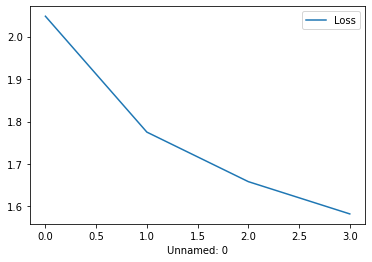

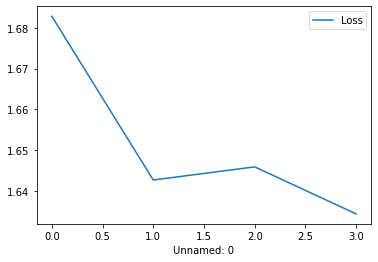

In [ ]:
# Plot the loss
train_loss = pd.read_csv("outputs/"+"train_loss.csv", sep="=")
train_loss.plot(0,2)
val_loss = pd.read_csv("outputs/"+"val_loss.csv", sep="=")
val_loss.plot(0,2)

In [ ]:
!zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/logs.txt (deflated 72%)
  adding: outputs/val_loss.csv (deflated 23%)
  adding: outputs/train_loss.csv (deflated 20%)
  adding: outputs/model_files/ (stored 0%)
  adding: outputs/model_files/config.json (deflated 63%)
  adding: outputs/model_files/spiece.model (deflated 48%)
  adding: outputs/model_files/tokenizer_config.json (deflated 80%)
  adding: outputs/model_files/pytorch_model.bin (deflated 8%)
  adding: outputs/model_files/special_tokens_map.json (deflated 83%)
  adding: outputs/predictions.csv (deflated 64%)
